<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/3D_Reconstruction_Pose_Depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading sample dataset

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
ids = ['1Hk38P1sqyCOuOTAmodF0VK6tgGj61qdb']
zip_files = ['data.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file
!unzip -q data/Frames_S7.zip -d data/

replace Frames_S7/cam.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!pip -q install matplotlib==3.4

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R
import torch

class CameraPoseVisualizerSlim:
    """
    Adapted from https://github.com/demul/extrinsic2pyramid
    """
    def __init__(self, xlim=[-5, 15], ylim=[0, 20],zlim=[-5, 15]):
        self.fig = plt.figure(figsize=(10, 10), constrained_layout=True)
        self.fig.patch.set_alpha(0)

        self.subfigs = self.fig.subfigures(nrows=1, ncols=1)

        self.ax3d1 = self.subfigs.add_subplot(1, 1, 1, projection='3d', facecolor="none")

        self.ax3d1.set_xlim(xlim)
        self.ax3d1.set_ylim(ylim)
        self.ax3d1.set_zlim(zlim)

        self.ax3d1.set_box_aspect(aspect =(xlim[1]-xlim[0],ylim[1]-ylim[0],zlim[1]-zlim[0]))


        self.intrinsics = np.eye(3)
        self.intrinsics[0, 0] = 237.5
        self.intrinsics[0, 2] = 237.5
        self.intrinsics[1, 1] = 237.5
        self.intrinsics[1, 2] = 237.5


    def extrinsic2pyramidAbs(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.7):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]

        self.ax3d1.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))


    def customize_legend(self):
        list_handle = []
        list_handle.append(Patch(color='c', label='Ground truth'))
        list_handle.append(Patch(color='y', label='Prediction'))

        self.ax3d2.legend(loc='upper left', handles=list_handle)


    def show(self, name='deleteme'):
        plt.savefig(name + '.png', bbox_inches='tight',pad_inches=0)

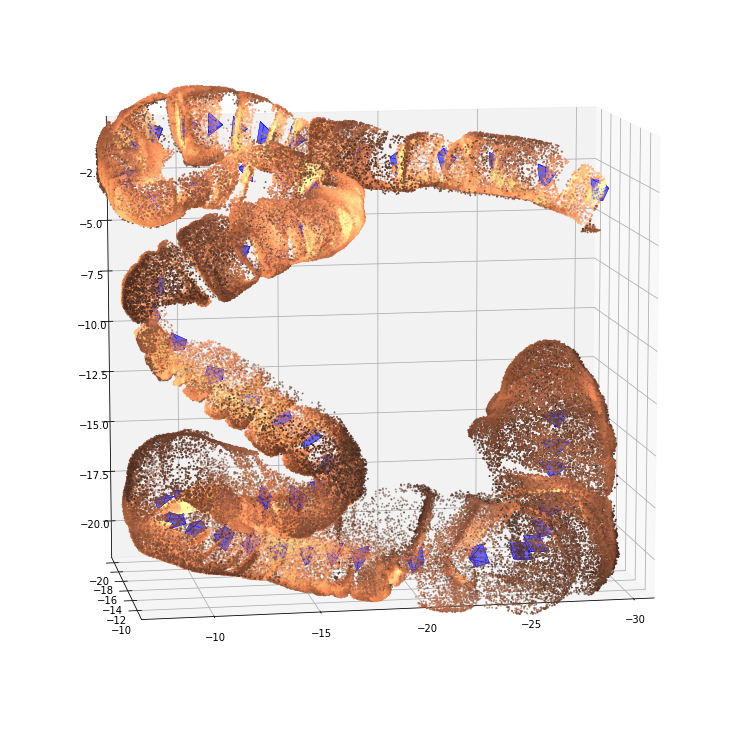

In [2]:
import torch
from skimage.transform import resize as imresize
import numpy as np

import matplotlib.pyplot as plt
#from camera_visualizer import CameraPoseVisualizerSlim
from scipy.spatial.transform import Rotation as R
import collections
from PIL import Image
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def set_id_grid(depth):
    b, h, w = depth.size()
    i_range = torch.arange(0, h).view(1, h, 1).expand(
        1, h, w).type_as(depth)  # [1, H, W]
    j_range = torch.arange(0, w).view(1, 1, w).expand(
        1, h, w).type_as(depth)  # [1, H, W]
    ones = torch.ones(1, h, w).type_as(depth)
    return torch.stack((j_range, i_range, ones), dim=1)  # [1, 3, H, W]

def pixel2cam(depth, intrinsics_inv):
    b, h, w = depth.size()
    pixel_coords = set_id_grid(depth)
    current_pixel_coords = pixel_coords[:, :, :h, :w].expand(
        b, 3, h, w).reshape(b, 3, -1)  # [B, 3, H*W]
    cam_coords = (intrinsics_inv @ current_pixel_coords).reshape(b, 3, h, w)
    return cam_coords * depth.unsqueeze(1)

def plot_growing_cloud(datasetname, scene, data_root):
    locations = []
    rotations = []
    loc_reader = open(data_root +'SavedPosition_' + datasetname + scene + '.txt', 'r')
    rot_reader = open(data_root +'SavedRotationQuaternion_' + datasetname + scene + '.txt',
                      'r')
    for line in loc_reader:
        locations.append(list(map(float, line.split())))
    loc_reader.close

    for line in rot_reader:
        rotations.append(list(map(float, line.split())))
    rot_reader.close

    locations = np.array(locations)  # in cm
    rotations = np.array(rotations)
    poses = np.concatenate([locations, rotations], 1)

    r = R.from_quat(rotations).as_matrix()

    TM = np.eye(4)
    TM[1, 1] = -1

    poses_mat = []
    for i in range(locations.shape[0]):
        ri = r[i]  # np.linalg.inv(r[0])
        Pi = np.concatenate((ri, locations[i].reshape((3, 1))), 1)
        Pi = np.concatenate((Pi, np.array([0.0, 0.0, 0.0, 1.0]).reshape((1, 4))), 0)
        Pi_left = TM @ Pi @ TM
        poses_mat.append(Pi_left)

    visualizer = CameraPoseVisualizerSlim([np.min(np.array(poses_mat)[:,0,-1]), np.max(np.array(poses_mat)[:,0,-1])],
                                          [np.min(np.array(poses_mat)[:,1,-1]), np.max(np.array(poses_mat)[:,1,-1])],
                                          [np.min(np.array(poses_mat)[:,2,-1]), np.max(np.array(poses_mat)[:,2,-1])])

    if datasetname == 'S':
        visualizer.ax3d1.view_init(elev=10, azim=80)
    elif datasetname == 'B':
        visualizer.ax3d1.view_init(elev=-30, azim=30)
    else:
        visualizer.ax3d1.view_init(elev=10, azim=30)

    intrinsics = np.eye(3)
    intrinsics[0, 0] = 227.6
    intrinsics[0, 2] = 227.6
    intrinsics[1, 1] = 237.5
    intrinsics[1, 2] = 237.5

    for j in range(0, len(poses_mat), 5):
        gt = poses_mat[j]
        depth0 = np.array(Image.open(data_root +'Frames_'+datasetname + scene + '/Depth_' + str(j).zfill(4) + '.png'))/256/255 * 20

        im0 = plt.imread(data_root + 'Frames_'+datasetname + scene + '/FrameBuffer_' + str(j).zfill(4) + '.png')
        im0 = im0[:, :, :3].reshape((-1, 3))

        cam_coords0 = pixel2cam(torch.tensor(depth0.reshape((1, 475, 475))).float(),
                                torch.tensor(intrinsics).inverse().float())
        cam_coords_flat0 = cam_coords0.reshape(1, 3, -1).numpy()

        rot_gt, tr_gt = gt[:3, :3], gt[:3, -1:]
        cloud_gt = rot_gt @ cam_coords_flat0 + tr_gt
        indeces = np.random.choice(225625, size=1000, replace=False)

        visualizer.ax3d1.scatter(cloud_gt[0, 0, indeces], cloud_gt[0, 1, indeces], cloud_gt[0, 2, indeces],
                                 c=im0[indeces, :],
                                 s=1)
        if j % 20 == 0:
            visualizer.extrinsic2pyramidAbs(poses_mat[j], 'b', 0.7)
    visualizer.show('pointcloud_' + datasetname + '_' + scene)

if __name__ == "__main__":
    datasetname = 'S'
    scene = '7'
    data_root = 'data/'
    #plot_growing_cloud(datasetname, scene, data_root)
    locations = []
    rotations = []
    loc_reader = open(data_root +'SavedPosition_' + datasetname + scene + '.txt', 'r')
    rot_reader = open(data_root +'SavedRotationQuaternion_' + datasetname + scene + '.txt',
                      'r')
    for line in loc_reader:
        locations.append(list(map(float, line.split())))
    loc_reader.close

    for line in rot_reader:
        rotations.append(list(map(float, line.split())))
    rot_reader.close

    locations = np.array(locations)  # in cm
    rotations = np.array(rotations)
    poses = np.concatenate([locations, rotations], 1)

    r = R.from_quat(rotations).as_matrix()

    TM = np.eye(4)
    TM[1, 1] = -1

    poses_mat = []
    for i in range(locations.shape[0]):
        ri = r[i]  # np.linalg.inv(r[0])
        Pi = np.concatenate((ri, locations[i].reshape((3, 1))), 1)
        Pi = np.concatenate((Pi, np.array([0.0, 0.0, 0.0, 1.0]).reshape((1, 4))), 0)
        Pi_left = TM @ Pi @ TM
        poses_mat.append(Pi_left)

    visualizer = CameraPoseVisualizerSlim([np.min(np.array(poses_mat)[:,0,-1]), np.max(np.array(poses_mat)[:,0,-1])],
                                          [np.min(np.array(poses_mat)[:,1,-1]), np.max(np.array(poses_mat)[:,1,-1])],
                                          [np.min(np.array(poses_mat)[:,2,-1]), np.max(np.array(poses_mat)[:,2,-1])])

    if datasetname == 'S':
        visualizer.ax3d1.view_init(elev=10, azim=80)
    elif datasetname == 'B':
        visualizer.ax3d1.view_init(elev=-30, azim=30)
    else:
        visualizer.ax3d1.view_init(elev=10, azim=30)

    intrinsics = np.eye(3)
    intrinsics[0, 0] = 227.6
    intrinsics[0, 2] = 227.6
    intrinsics[1, 1] = 237.5
    intrinsics[1, 2] = 237.5
    
    for j in range(0, len(poses_mat), 5):
        gt = poses_mat[j]
        depth0 = np.array(Image.open(data_root +'Frames_'+datasetname + scene + '/Depth_' + str(j).zfill(4) + '.png'))/256/255 * 20

        im0 = plt.imread(data_root + 'Frames_'+datasetname + scene + '/FrameBuffer_' + str(j).zfill(4) + '.png')
        im0 = im0[:, :, :3].reshape((-1, 3))

        cam_coords0 = pixel2cam(torch.tensor(depth0.reshape((1, 475, 475))).float(),
                                torch.tensor(intrinsics).inverse().float())
        cam_coords_flat0 = cam_coords0.reshape(1, 3, -1).numpy()

        rot_gt, tr_gt = gt[:3, :3], gt[:3, -1:]
        cloud_gt = rot_gt @ cam_coords_flat0 + tr_gt
        indeces = np.random.choice(225625, size=1000, replace=False)

        visualizer.ax3d1.scatter(cloud_gt[0, 0, indeces], cloud_gt[0, 1, indeces], cloud_gt[0, 2, indeces],
                                 c=im0[indeces, :],
                                 s=1)
        if j % 20 == 0:
            visualizer.extrinsic2pyramidAbs(poses_mat[j], 'b', 0.7)
        
        #if j == 5:
            #break
    visualizer.show('pointcloud_' + datasetname + '_' + scene)
    